## Books Text with Apache Spark 

---

In [1]:
# Setting up hostname
# sudo hostname -s 127.0.0.1

In [2]:
# Import libraries

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Finding SparkContext

import findspark
findspark.init() 

import pyspark
sc = pyspark.SparkContext()

In [4]:
# Import books

import os
os.listdir('tails')

['13chil.txt', '3lpigs.txt']

In [5]:
# Parsing a string into individual words, elimination of punctuation marks including "," and "." 

import re

def parsewords(sentence):
    # Convert all non-alphanumeric characters into empty string
    sentence_clean = re.sub(r'([^A-Za-z0-9\s+])', '', sentence)  
    words = sentence_clean.split(' ')
    # Convert to lowercase and eliminate empty string words
    return [word.lower() for word in words if word != ''] 

In [6]:
# Function test 

sample_sentence = "I shall finish my house first. It must be solid and sturdy. \
And then I'll come and play!" "I shall not be foolish like you!\
For he who laughs last, laughs longest!"

parsewords(sample_sentence)[:10]

['i', 'shall', 'finish', 'my', 'house', 'first', 'it', 'must', 'be', 'solid']

In [7]:
# Load books text, RDD (Resilient Distributed Datasets)

textsRDD = sc.textFile('tails/'+os.listdir('tails')[0])
for txt in os.listdir('tails')[1:]:
    file_dir = 'tails/' + txt
    textRDD = sc.textFile(file_dir)
    textsRDD = textsRDD.union(textRDD)
    
textsRDD.take(20)

['                                FOR CHILDREN:',
 '',
 '                                   Sly Fox',
 '',
 '    Mr. Rabbit sat on his front porch rocking, eating a great big carrot, ',
 'and looking.',
 '',
 '    "Looks like Sly Fox coming down the road," he said to himself, walking ',
 'to the end of the porch. Shading his eyes with his paws, he exclaimed, "It ',
 'is Sly Fox." ',
 '',
 '    "Good morning Mr. Rabbit," cried Sly Fox, as he walked across the yard. ',
 '"Good morning," replied Mr. Rabbit, a slight frown on his face. ',
 '',
 '    "Well," said Sly Fox, "as I haven\'t seen you in so long a time, thought ',
 'I would stop and chat a while." ',
 '',
 '    Mr. Rabbit could not be rude in his own home, even to an enemy, so he ',
 'offered Sly Fox a seat on the porch. ',
 '']

In [8]:
# textsRDD with parsewords for each line of strings 

textsRDD.map(parsewords).take(5) 

[['for', 'children'],
 [],
 ['sly', 'fox'],
 [],
 ['mr',
  'rabbit',
  'sat',
  'on',
  'his',
  'front',
  'porch',
  'rocking',
  'eating',
  'a',
  'great',
  'big',
  'carrot']]

In [9]:
# flatMap method with parsewords 

wordRDD = textsRDD.flatMap(parsewords)
wordRDD.take(20)

['for',
 'children',
 'sly',
 'fox',
 'mr',
 'rabbit',
 'sat',
 'on',
 'his',
 'front',
 'porch',
 'rocking',
 'eating',
 'a',
 'great',
 'big',
 'carrot',
 'and',
 'looking',
 'looks']

In [10]:
# Total number of words 

total_count = wordRDD.count()
print ("Total Word Count:", total_count)

Total Word Count: 2454


In [11]:
# Convert individual word into a pair of (word,1) tuple 

wordPairRDD = wordRDD.map(lambda word: (word,1))
wordPairRDD.take(20)

[('for', 1),
 ('children', 1),
 ('sly', 1),
 ('fox', 1),
 ('mr', 1),
 ('rabbit', 1),
 ('sat', 1),
 ('on', 1),
 ('his', 1),
 ('front', 1),
 ('porch', 1),
 ('rocking', 1),
 ('eating', 1),
 ('a', 1),
 ('great', 1),
 ('big', 1),
 ('carrot', 1),
 ('and', 1),
 ('looking', 1),
 ('looks', 1)]

In [12]:
# ReduceByKey method to sum up the counts, create a new RDD, wordCountRDD.

wordCountRDD = wordPairRDD.reduceByKey(lambda x,y: x+y)
wordCountRDD.take(20)

[('rabbit', 33),
 ('eating', 1),
 ('like', 7),
 ('road', 2),
 ('he', 56),
 ('of', 35),
 ('eyes', 3),
 ('exclaimed', 2),
 ('good', 7),
 ('walked', 1),
 ('yard', 2),
 ('i', 14),
 ('in', 34),
 ('long', 6),
 ('thought', 6),
 ('would', 3),
 ('even', 1),
 ('an', 4),
 ('offered', 1),
 ('chair', 1)]

In [13]:
# Number of unique words

unique_count = wordCountRDD.count()
print ("Total Unique Words:", unique_count)

Total Unique Words: 757


In [14]:
# Select top 20 words in descending order of frequency

top50Words = wordCountRDD.takeOrdered(20, key=lambda x: -x[1]) # Use '-' to sort in descending order
top50Words

[('the', 162),
 ('and', 91),
 ('to', 71),
 ('he', 56),
 ('a', 51),
 ('little', 37),
 ('of', 35),
 ('his', 35),
 ('in', 34),
 ('rabbit', 33),
 ('fox', 30),
 ('sly', 26),
 ('with', 23),
 ('as', 21),
 ('for', 20),
 ('they', 20),
 ('on', 18),
 ('had', 18),
 ('you', 16),
 ('house', 16)]

In [15]:
# Top 50 words simplified with Spark

top50Words = (textsRDD.flatMap(parsewords)
                      .map(lambda word: (word,1))
                      .reduceByKey(lambda x,y: x+y)
                      .takeOrdered(50, key=lambda x: -x[1]))

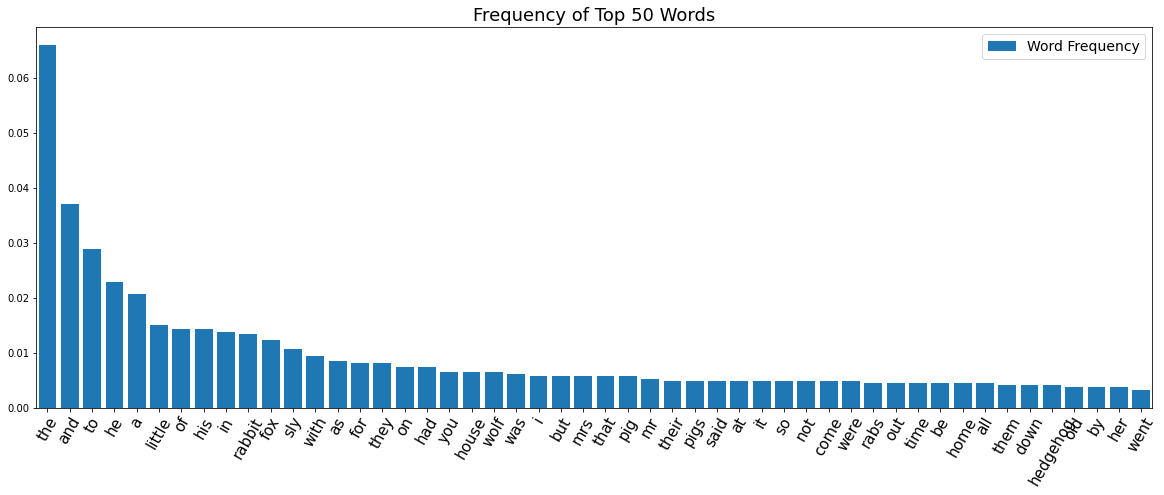

In [16]:
# Plot frequency of top 50 words

words = list()
counts = list()
for pair in top50Words:
    words.append(pair[0])
    counts.append(pair[1])

plt.figure(figsize=(20,7))
plt.bar(range(1,51), np.array(counts) / float(total_count), label="Word Frequency", align='center')
plt.xticks(range(1,51), words[:50], rotation=60, fontsize=15)
plt.title("Frequency of Top 50 Words",fontsize=18)
plt.legend(fontsize=14)
plt.xlim(0.5,50.5)
plt.show()